# Aproximación del modelo SABR a través de una red neuronal

Objetivo: obtener los parámetros del SABR $ \alpha, \rho, \nu$ para un smile dado, tomando como inputs de la red los precios de ejercicio junto a sus correspondientes volatilidades normales y el tiempo a vencimiento de la opción (maturity).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('C:\\Archivos\\TFM\\code')
data = pd.read_csv('Smile_30_4_2019.csv', sep = ',', header = 0, index_col = False, engine = 'python')

Importo y preparo los datos de mercado de los swaptions

In [2]:
data.head()

,Reference,StrikeATMdiff,Forward_Rate,Volatility
0,EUR_1M_1Y,-10,-0.003126,0.000919
1,EUR_1M_1Y,-7,-0.003126,0.000767
2,EUR_1M_1Y,-5,-0.003126,0.000668
3,EUR_1M_1Y,-2,-0.003126,0.000624
4,EUR_1M_1Y,-1,-0.003126,0.000641


In [3]:
data[['Currency','Maturity','IRS_duration']] = data.Reference.str.split("_", expand = True)

In [4]:
matur = data.Maturity.str.extract('(\d+)([MY])', expand = True)

In [5]:
T = []
for i in range(len(matur)):
    if matur.iloc[i,1] == 'M':
        aux = pd.to_numeric(matur.iloc[i,0]) / 12
        T.append(aux)
    else:
        T.append(matur.iloc[i,0])

In [6]:
def strikeABS(K_bps, FR):
    K = FR + K_bps/10000
    return K

length = int(len(data) / 11); Xmarket = np.zeros((length,23))
for i in range(length):
    strike = []; vol = []
    for j in range(11):
        Kaux = strikeABS(pd.to_numeric(data.StrikeATMdiff[j + 11*i]),pd.to_numeric(data.Forward_Rate[j + 11*i]))
        strike.append(Kaux)
        vol.append(pd.to_numeric(data.Volatility[j + 11*i]))
    Xmarket[i,:] = np.hstack((strike,vol, T[11*i]))

## Testeo de la red neuronal con los datos generados a partir de la ecuación de Hagan

Con este fin comparamos la volatilidad normal para los distintos strikes obtenida por la red neuronal con la utilizada para obtener las volatilidades. En la primera ventana de test se puede ver las volatilidades obtenidas por ambos métodos para una muestra aleatoria del Test Set utilizado para entrenar la red neuronal, mientras que en la segunda aparece el error relativo entre estas dos volatilidades.

La red neuronal tiene 6 capas y 64 neuronas con función de activación 'elu' en las capas ocultas

In [7]:
from keras.models import load_model
NN = load_model('volstoparams2.h5')
X = np.load('X_sample.npy'); testparams = np.load('y_sample.npy');
import SABRnormal

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


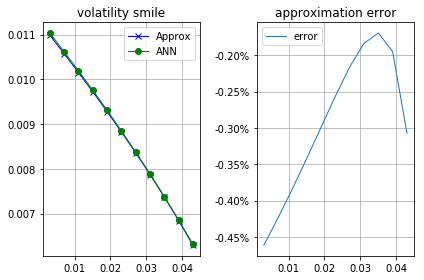

In [8]:
testcase = np.random.randint(0,len(X)) ; Xtestcase = np.ravel(X[-testcase,:]);
testparams = np.ravel(NN.predict(X[-testcase,:].reshape(1,-1)))
vol_test = []; 
for j in range(11):
    aux = SABRnormal.normal_vol(Xtestcase[j],Xtestcase[5],Xtestcase[-1],testparams[0],0,testparams[1],testparams[2],0)
    vol_test.append(aux)

plt.figure()
plt.subplot(121)
plt.plot(Xtestcase[:11], Xtestcase[11:-1], color = 'blue', marker = 'x', linewidth = 1.0);
plt.plot(Xtestcase[:11],np.array(vol_test), color = 'green', marker = 'o', linewidth = 1.0);
plt.grid(True); plt.legend(['Approx','ANN']); plt.title('volatility smile')

plt.subplot(122)
plt.plot(Xtestcase[:11], (Xtestcase[11:-1] - np.squeeze(vol_test))/Xtestcase[11:-1], linewidth = 1.0);
plt.grid(True); plt.legend(['error']); plt.title('approximation error')
plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.tight_layout()

En la siguiente tabla se muestra el error de mapeo para cada Strike (en bp) a través de la métrica RMSE.

In [9]:
testsize = 1000; error_test = np.zeros((testsize,11))
for testcase in range(1,testsize + 1):
    Xtestcase = np.ravel(X[-testcase,:]);
    testparams = np.ravel(NN.predict(X[-testcase,:].reshape(1,-1)))
    vol_test = []; 
    for j in range(11):
        aux = SABRnormal.normal_vol(Xtestcase[j],Xtestcase[5],Xtestcase[-1],testparams[0],0,testparams[1],testparams[2],0)
        vol_test.append(aux)
    error_test[testcase-1] = (Xtestcase[11:-1] - vol_test)
RMSE = np.sqrt(np.sum(np.square(error_test), axis = 0)/testsize)
title = np.linspace(-200,200,11)
pd.DataFrame(RMSE.reshape(1,-1),index = None, columns = title)

,-200.0,-160.0,-120.0,-80.0,-40.0,0.0,40.0,80.0,120.0,160.0,200.0
0,0.000476,0.000417,0.00036,0.000306,0.000259,0.000232,0.000259,0.000305,0.000359,0.000416,0.000474


Parece que la red neuronal reduce su error en el tramo central respecto a los strikes más extremos

## Testeo de la red neuronal con datos de mercado

Ahora veremos como de bien ajusta la red neuronal a un set completo de Swaptions.

In [10]:
parameters = np.zeros((len(Xmarket),3))
for i in range(len(Xmarket)):
    parameters[i] = NN.predict(Xmarket[i,:].reshape(1,-1))

Maturity: 10.0 Forward Rate:0.013402630572


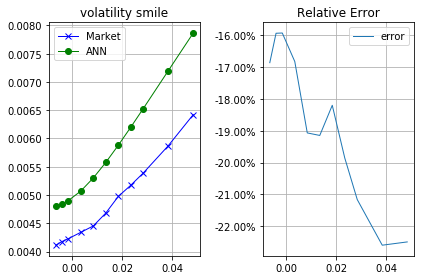

In [11]:
import SABRnormal
import matplotlib.pyplot as plt
testcase = np.random.randint(0,len(Xmarket)-1);
Xtestcase = np.ravel(Xmarket[testcase,:]);
vol_test = []; 
for j in range(11):
    aux = SABRnormal.normal_vol(Xtestcase[j],Xtestcase[4],Xtestcase[-1],parameters[testcase,0],0,parameters[testcase,1],parameters[testcase,2],0)
    vol_test.append(aux)
print('Maturity: ' + str(Xmarket[testcase,-1]) + ' Forward Rate:' + str(Xmarket[testcase,5]))
plt.figure()
plt.subplot(121)
plt.plot(Xtestcase[:11], Xtestcase[11:-1], color = 'blue', marker = 'x', linewidth = 1.0);
plt.plot(Xtestcase[:11],np.array(vol_test), color = 'green', marker = 'o', linewidth = 1.0);
plt.grid(True); plt.legend(['Market','ANN']); plt.title('volatility smile')

plt.subplot(122)
plt.plot(Xtestcase[:11], (Xtestcase[11:-1] - np.ravel(vol_test))/Xtestcase[11:-1], linewidth = 1.0);
plt.grid(True); plt.legend(['error']); plt.title('Relative Error')
plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.tight_layout()

In [12]:
error_test = np.zeros((len(Xmarket),11))
for testcase in range(len(Xmarket)):
    Xtestcase = np.ravel(Xmarket[testcase,:]);
    testparams = np.ravel(NN.predict(X[testcase,:].reshape(1,-1)))
    vol_test = []; 
    for j in range(11):
        aux = SABRnormal.normal_vol(Xtestcase[j],Xtestcase[5],Xtestcase[-1],testparams[0],0,testparams[1],testparams[2],0)
        vol_test.append(aux)
    error_test[testcase] = (Xtestcase[11:-1] - vol_test)
RMSE = np.sqrt(np.sum(np.square(error_test), axis = 0)/testsize)
title = np.linspace(-200,200,11)
pd.DataFrame(RMSE.reshape(1,-1),index = None, columns = title)

,-200.0,-160.0,-120.0,-80.0,-40.0,0.0,40.0,80.0,120.0,160.0,200.0
0,0.00327,0.003189,0.003098,0.002987,0.002881,0.002798,0.002721,0.002691,0.002693,0.002794,0.003008
